<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/last/01_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn imbalanced-learn "ray[tune]"

# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [2]:
# @title LogReg from scratch (BCE)
class LogisticRegressionScratchBCE(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.w = None
        self.b = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def predict(self, X):
        # Compute linear combination
        z = np.dot(X, self.w) + self.b

        # Use a stable sigmoid to prevent overflow
        z = np.clip(z, -500, 500)  # prevents overflow in exp()
        probs = 1 / (1 + np.exp(-z))

        # Threshold at 0.5
        return (probs >= 0.5).astype(int)

    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.b
        probs = self.sigmoid(z)
        # Return as two columns: [P(class=0), P(class=1)]
        return np.column_stack((1 - probs, probs))


    def initialize_weights(self, n_features):
        self.w = np.zeros((n_features, 1))  # Init with the same column number as feature
        self.b = 0

    def cost_function(self, h, y):
        m = len(y)
        # reg_term = (0.01 / (2 * m)) * np.sum(self.w ** 2)
        cost = -(1 / m) * np.sum(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))

        return cost #+ reg_term

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)  # Ensure y is a column vector
        print(X.shape, y.shape)
        m = len(y)
        n_features = X.shape[1]
        self.initialize_weights(n_features)

        for i in range(self.num_iterations):
            # Forward prop
            probs = self.predict(X)

            # Cost
            # error = -(1 / m) * np.sum(y * np.log(probs + 1e-8) + (1 - y) * np.log(1 - probs + 1e-8))
            error = self.cost_function(probs, y)
            self.losses.append(error)

            # Calculate the gradient of the error with respect to the weights
            gradient_w = (1 / m) * np.dot(X.T, (probs - y))
            gradient_b = (1 / m) * np.sum(probs - y)

            # Update the weights using the gradient and the learning rate
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b

            # cost compute if more iteration (optional)
            # if i % 100 == 0:
            #     print(f"Iteration {i}, Cost: {error}")

    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(range(self.num_iterations), self.losses, label='MSE Loss')
        plt.xlabel("Iteration")
        plt.ylabel("Loss (MSE)")
        plt.title("Loss Curve: Logistic Regression (BCE)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [3]:
import kagglehub
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"
df = pd.read_csv(file_path)
df.head()

100%|██████████| 4.47M/4.47M [00:01<00:00, 3.35MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [4]:
df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


/tmp/ipython-input-2508231616.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


In [5]:
df

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [6]:
df_unique

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
116,C_10,alive,2005,1891.392,1986.452,347.652,1001.503,133.394,176.267,497.702,...,2987.955,11322.645,2608.455,653.851,1001.503,2272.073,1358.832,2987.955,7897.681,1986.452
1200,C_100,alive,2001,19.137,11.137,3.112,8.347,0.293,8.461,2.154,...,25.384,82.517,0.000,5.235,14.247,5.408,66.819,25.384,6.298,17.037
11934,C_1000,alive,2007,2333.035,2531.727,160.989,1846.419,350.668,1013.559,1189.205,...,6772.281,6357.336,1197.425,1685.430,4240.554,2656.860,5539.134,6772.281,4750.686,4925.862
11950,C_1001,alive,2003,13004.200,66153.600,126.000,1040.300,6735.100,646.500,5418.800,...,69506.100,16240.200,1209.800,914.300,3352.500,9456.100,3405.000,69506.100,11074.900,68465.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11857,C_995,alive,2000,1076.559,2955.617,146.214,613.684,408.550,200.967,538.403,...,4247.504,2668.924,451.336,467.470,1291.887,971.687,1159.964,4247.504,2082.185,3633.820
11865,C_996,alive,2001,62.788,74.934,3.346,-0.613,36.729,-4.989,25.152,...,91.550,102.646,0.000,-3.959,16.616,75.197,20.945,91.550,77.640,92.163
11866,C_997,alive,1999,490.600,1231.300,57.400,253.300,234.200,103.300,213.900,...,2006.900,1188.800,241.400,195.900,775.600,470.600,208.600,2006.900,806.400,1753.600
11898,C_998,failed,2011,1537.185,2897.999,82.391,335.109,287.390,138.730,499.194,...,3445.110,2992.814,84.794,252.718,547.111,1021.776,137.073,3445.110,1259.102,3110.001


In [7]:
X = df_unique[
    ["X8", "X17", "X3", "X11", "X15", "X1", "X6"]
]
y = df_unique["status_label"].map({"alive": 0, "failed": 1})

In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 6706
Bankruptcy: 470


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [11]:

sm = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [12]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 6706
Bankruptcy: 6706


In [16]:
params = {
    "learning_rate": [1e-2, 1e-3, 1e-4],
    "num_iterations": [1000, 5000, 10000],
}

grid_dt = GridSearchCV(LogisticRegressionScratchBCE(), params, cv=8, scoring="f1")
grid_dt.fit(X_train, y_train)
print("Best parameters:", grid_dt.best_params_)
print("Best score:", grid_dt.best_score_)

(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11736, 7) (11736, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11735, 7) (11735, 1)
(11736, 7) (11736, 1)
(11736, 7)

In [17]:

learning_rate = 0.01
num_iterations = 1000

In [18]:
BCEmodel_scratch = LogisticRegressionScratchBCE(learning_rate=learning_rate, num_iterations=num_iterations)
BCEmodel_scratch

LogisticRegressionScratchBCE()

In [19]:
BCEmodel_scratch.fit(X_train, y_train)

(13412, 7) (13412, 1)


In [20]:
BCE_pred_scratch = BCEmodel_scratch.predict(X_test)


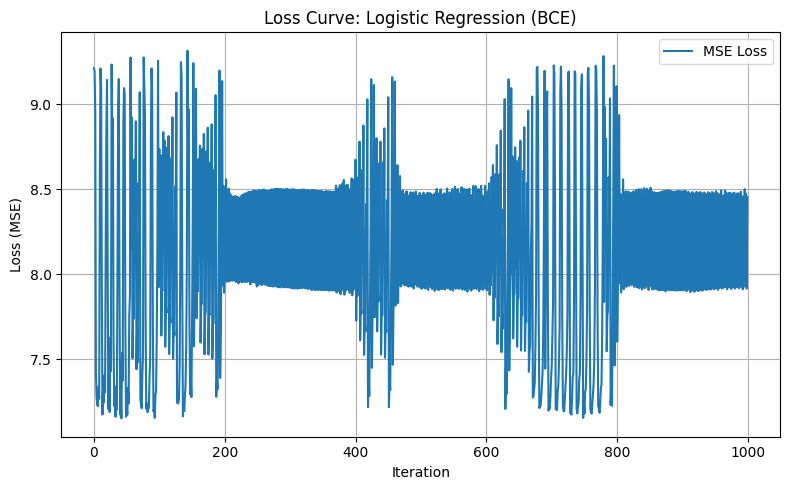

In [21]:
BCEmodel_scratch.plot_loss()


In [22]:
from sklearn.metrics import accuracy_score, f1_score
score = accuracy_score(y_test, BCE_pred_scratch)
print("Accuracy:", score)
score = f1_score(y_test, BCE_pred_scratch)
print("F1_score:", score)

Accuracy: 0.46852367688022284
F1_score: 0.1733102253032929


In [23]:
def predict(model):
    model.fit(X_train, y_train)
    model.predict(X_test)
    print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

In [24]:
predict(BCEmodel_scratch)

(13412, 7) (13412, 1)
              precision    recall  f1-score   support

           0       0.95      0.45      0.61      1656
           1       0.10      0.72      0.17       139

    accuracy                           0.47      1795
   macro avg       0.52      0.58      0.39      1795
weighted avg       0.88      0.47      0.57      1795



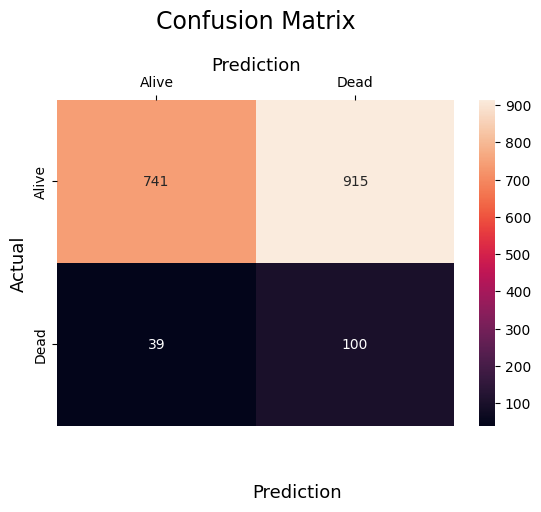

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, BCE_pred_scratch)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

Logistic: ROC AUC=0.619


/tmp/ipython-input-3831337299.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


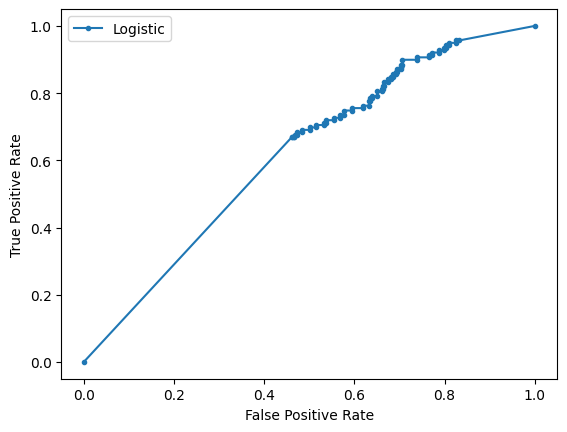

In [26]:
# ROC & AUC

# predict probabilities
lr_probs = BCEmodel_scratch.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [27]:
Model_LR = LogisticRegression()
predict(Model_LR)


              precision    recall  f1-score   support

           0       0.96      0.33      0.49      1656
           1       0.10      0.85      0.17       139

    accuracy                           0.37      1795
   macro avg       0.53      0.59      0.33      1795
weighted avg       0.90      0.37      0.46      1795



Logistic: ROC AUC=0.633


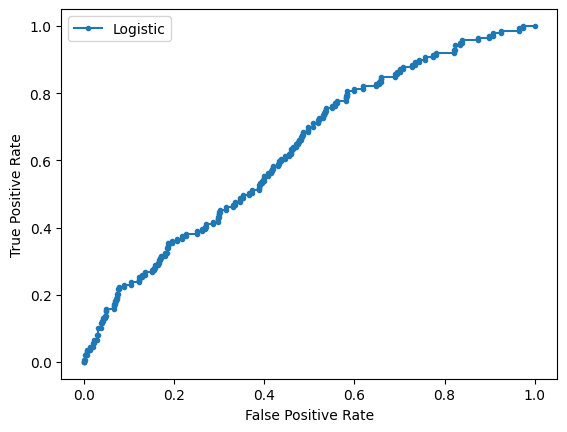

In [28]:
# ROC & AUC
Model_LR = LogisticRegression()
Model_LR.fit(X_train, y_train)
# predict probabilities
lr_probs = Model_LR.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()